# **5. ML - Classification**

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Guardado del modelo
import joblib

In [2]:
# Cargar el archivo CSV
df = pd.read_csv('../data/processed/campana_marketing.csv', parse_dates=['Dt_Customer'])

# Convertir la columna 'Income' de float64 a int64
df['Income'] = df['Income'].astype('int64')

## Nuestra variable objetivo será `AcceptedCmp`: 0 no se ha aceptado ninguna campaña y 1 se ha aceptado al menos 1 de las 5 campañas

In [3]:
# 1. Correlación con el Target
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix['AcceptedCmp'].sort_values(ascending=False)
correlation_with_target

AcceptedCmp            1.000000
AcceptedCmp4           0.553782
AcceptedCmp3           0.551957
AcceptedCmp5           0.548292
AcceptedCmp1           0.510624
MntWines               0.465034
Spent                  0.412466
Response               0.367401
Income                 0.315024
NumCatalogPurchases    0.313291
MntMeatProducts        0.274626
AcceptedCmp2           0.229464
NumWebPurchases        0.213228
MntGoldProds           0.190782
NumStorePurchases      0.186765
MntFishProducts        0.160046
MntSweetProducts       0.159584
MntFruits              0.126553
Education              0.047823
Age                    0.030778
Marital_Status        -0.000198
Days                  -0.013751
Seniority             -0.013751
Recency               -0.017745
Complain              -0.027016
Year_Birth            -0.030778
ID                    -0.041206
NumDealsPurchases     -0.086570
Teenhome              -0.099415
NumWebVisitsMonth     -0.125986
Kidhome               -0.203024
Child_Ho

## Selección de variables X e Y

1. Determinamos que las variables con una correlación entre 0.2 y -0.2 quedarán excluidas de nuestro entrenamiento, ya que se encuentran entorno al 0 y parecen que no afectan a la variable objetivo y así aligeramos el proceso de entrenamiento.
2. Usando una **list comprehension** eliminamos las características `AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5 y Response`, ya que son o subproducto de AcceptedCmp o bien una característica condicionada.

In [4]:
# Filtrar correlaciones fuera del rango [-0.2, 0.2]
filtered_correlations = correlation_with_target[
    correlation_with_target.abs() > 0.2
].sort_values(ascending=False)

# Lista final de features, excluyendo las variables derivadas de 'AcceptedCmp'
excluded_features = ['AcceptedCmp', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
features = [f for f in filtered_correlations.index if f not in excluded_features]

print("Características seleccionadas:", features)

Características seleccionadas: ['MntWines', 'Spent', 'Income', 'NumCatalogPurchases', 'MntMeatProducts', 'NumWebPurchases', 'Kidhome', 'Child_Home']


Definimos las variables

In [5]:
X = df[features]
y = df['AcceptedCmp']

## División de datos
Cogeremos el 20% para test y el 80% para training

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tratamiento del Desbalance de Clases
Como vimos en [**EDA**](04_explore_data.ipynb), al final del análisis no gráfico, `AcceptedCmp` tiene la clase está desbalanceada.
En este escenario, la clase minoritaria (en nuestro caso, la clase 1) está significativamente menos representada que la clase mayoritaria (la clase 0). Esto puede generar varios problemas al entrenar un modelo de clasificación.

### Rebalancear clases
Optamos por hacer un Submuestreo (**Undersampling**), reduciendo el número de ejemplos de la clase mayoritaria.

Dada la significativa disparidad en la representación de las clases en nuestro conjunto de datos, con una marcada predominancia de la clase mayoritaria (clase 0), se ha optado por aplicar la técnica de submuestreo (undersampling). El objetivo principal de esta estrategia es reducir el número de instancias de la clase mayoritaria para mitigar el sesgo del modelo hacia esta clase y mejorar su capacidad para aprender y predecir la clase minoritaria (clase 1) de manera más efectiva.

In [7]:
# Aplicar undersampling para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

## Estandarización con `StandardScaler`
1. Se estandarizan los datos para el entrenamiento de modelos de **Regresión Logística** y **SVM** porque son sensibles a la escala de las características, lo que puede afectar su convergencia y rendimiento. 
2. Para **KNN** y **Random Forest**, la estandarización no es estrictamente necesaria debido a su funcionamiento basado en distancias relativas o divisiones de características individuales. Para **XGBoost** tampoco es necesario, ya que maneja bien los valores numéricos y para **Redes Neuronales**, la decisión se toma considerando el contexto específico del experimento.

In [8]:
# Aplicamos StandardScaler solo a los datos originales (sin rebalanceo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Selección de modelos

Para el **Desbalance de Clases**, ajustamos pesos en el modelo (más fácil y eficiente) con `class_weight='balanced`.
En el caso de **XGBoost**, admite el ajuste de pesos con `scale_pos_weight` para manejar clases desbalanceadas, siendo `scale_pos_weight = n_negative / n_positive`, es decir, el número de muestras de la clase mayoritaria dividido por el de la clase minoritaria. Si la clase positiva es la minoritaria, el modelo le asignará más peso para compensar el desequilibrio.
Como los modelos **KNN** y **Neural Network** no son compatibles para que se ajusten, aquí sí que aplicaremos el undersampling `X_resampled, y_resample` que se ha hecho previamente.


Los datos ya estandarizados `X_train_scaled`se usarán solo para entrenar en los modelos **Logistic Regression** y **SVM**.

Se hará la **paralelización** con `n_jobs=-1` en los modelos que lo soporten para usar todos los núcleos disponibles y acelerar el entrenamiento de estos modelos.

In [33]:
# Modelos con ajuste de pesos para modelos compatibles
models = {
    'Logistic Regression': (LogisticRegression(max_iter=5000, class_weight='balanced', solver="lbfgs"), X_train_scaled, y_train),
    'KNN': (KNeighborsClassifier(n_jobs=-1), X_resampled, y_resampled),
    'Random Forest': (RandomForestClassifier(class_weight='balanced', n_jobs=-1), X_train, y_train),
    'SVM': (SVC(probability=True, class_weight='balanced'), X_train_scaled, y_train),
    'Neural Network': (MLPClassifier(solver='adam', batch_size='auto', max_iter=500), X_resampled, y_resampled),
    'XGBoost': (xgb.XGBClassifier(n_jobs=-1, tree_method="hist", device="cuda:0", predictor="gpu_predictor", scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),), X_train, y_train)
}

## Prevención de Overfitting
Para evitar sobreajuste de los modelos:

1. **En la definición de búsqueda de hiperparámetros (param_grid)**:

    - Se agregará regularización más fuerte: `C` más amplio en **Logistic Regression** y **SVM**.

    - Se usará `min_samples_split` y `min_samples_leaf` en **RandomForest**.

    - Se incluirá `early_stopping_rounds` en **XGBoost**.

2. **Para el entrenamiento**:

    - Se aplicará validación cruzada más intensiva (`cv=10`).

    - Se usará `n_jobs=-1` para acelerar procesamiento.

    - Se aplicará `early_stopping_rounds=10` en **XGBoost** para evitar sobreentrenamiento.

## Hiperparámetros para la Búsqueda Exhaustiva con GridSearchCV

In [34]:
# Hiperparámetros para GridSearchCV organizados por algoritmo
param_grid = {
    'Logistic Regression': [
        # Configuración para regularización L2 (Ridge)
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Fuerza de regularización (inverso)
            'penalty': ['l2'],  # Regularización Ridge (reduce coeficientes sin eliminarlos)
            'solver': ['lbfgs']  # Algoritmo adecuado para L2
        },
        # Configuración para regularización L1 (Lasso)
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1'],  # Regularización Lasso (puede eliminar características)
            'solver': ['liblinear']  # Requerido para L1
        }
    ],
    
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],  # Número de vecinos a considerar
        'weights': ['uniform', 'distance'],  # 'distance' da más peso a vecinos cercanos
        'p': [1, 2]  # 1: Distancia Manhattan, 2: Distancia Euclidiana
    },
    
    'Random Forest': {
        'n_estimators': [50, 100, 200, 500],  # Número de árboles en el bosque
        'max_features': ['sqrt', 'log2', None],  # Número de features a considerar para dividir
        'max_depth': [3, 5, 10, 20],  # Profundidad máxima de los árboles
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en nodos hoja
    },

    'SVM': {
        'C': [0.1, 1, 10, 100],  # Parámetro de regularización
        'gamma': ['scale', 'auto', 0.01, 0.1],  # Influencia de cada ejemplo de entrenamiento
        'kernel': ['linear', 'rbf']  # Tipo de función kernel
    },  # 🔹 Se agregó la coma aquí

    'Neural Network': {
        'hidden_layer_sizes': [
            (50,50),  # 2 capas con 50 neuronas cada una
            (100,),  # 1 capa oculta con 100 neuronas
            (100,50)  # Combinación compacta
        ],  
        'activation': ['relu'],  # Función de activación: 'relu' es más eficiente que 'tanh'
        'solver': ['adam'],  # Algoritmo de optimización: 'adam' es más rápido que 'sgd'
        'alpha': [0.0001, 0.001, 0.01],  # Término de regularización L2
        'learning_rate': ['constant']  # Tasa de aprendizaje: 'adaptive' a veces es inestable
    },  # 🔹 Se agregó la coma aquí

    'XGBoost': {
        'n_estimators': [100, 300, 500],  # Número de árboles de boosting
        'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje (eta)
        'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
        'subsample': [0.8, 0.9],  # Fracción de muestras para entrenar cada árbol
        'colsample_bytree': [0.8, 1.0],  # Fracción de features para cada árbol
        'reg_lambda': [1, 10],  # Regularización L2 (lambda)
        'reg_alpha': [0, 1]  # Regularización L1 (alpha)
    }
}

## Entrenamiento y recogida de resultados
Como `GridSearchCV` no lo permite directamente, para mantener `early_stopping_rounds` en **XGBoost**, hay que dividir los datos de entrenamiento en un conjunto de entrenamiento reducido y un conjunto de validación dentro del bucle for. Usamos `train_test_split` para crear estos conjuntos antes de llamar a `GridSearchCV.fit()`.

Intentamos que **XGBoost** entrene completamente en la GPU.

In [35]:
results = {}
best_models = {}

for model_name, (model, X_data, y_data) in models.items():
    print(f"\nEntrenando {model_name}...")
    
    # Configuración especial para XGBoost con GPU
    if model_name == 'XGBoost':
        # Dividir datos para early stopping (90% train, 10% validation)
        X_train_part, X_val, y_train_part, y_val = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data, random_state=42)
        
        # Configuración óptima para GPU
        gpu_params = {'tree_method': 'hist', 'device': 'cuda:0', 'predictor': 'gpu_predictor', 'early_stopping_rounds': 10, 'eval_metric': 'logloss', 'verbosity': 0}
        model.set_params(**gpu_params)
        
        # GridSearchCV optimizado para GPU
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], scoring='roc_auc', cv=10, n_jobs=1, refit=True)
        
        # Entrenamiento con validación temprana
        grid_search.fit(X_train_part, y_train_part, eval_set=[(X_val, y_val)], verbose=False)
    else:
        # Configuración estándar para otros modelos
        grid_search = GridSearchCV(model, param_grid[model_name], scoring='roc_auc', cv=10, n_jobs=-1)
        grid_search.fit(X_data, y_data)
    
    # Obtener el mejor modelo y sus parámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Seleccionar conjunto de test adecuado
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test
    
    # Predicciones y métricas
    y_pred = best_model.predict(X_test_final)
    y_pred_proba = (best_model.predict_proba(X_test_final)[:, 1] 
                   if hasattr(best_model, "predict_proba") 
                   else np.zeros_like(y_pred))
    
    # Almacenar resultados
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Best Params': best_params
    }
    best_models[model_name] = best_model

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
results_df[numeric_cols] = results_df[numeric_cols].astype(float).round(4)


Entrenando Logistic Regression...



Entrenando KNN...

Entrenando Random Forest...

Entrenando SVM...

Entrenando Neural Network...

Entrenando XGBoost...


## Evaluación y Análisis de los Resultados
### Resultados

In [36]:
print("\n🔹 Resultados de los modelos:")
print(results_df)

# Determinar el mejor modelo basado en diferentes métricas
best_metrics = {metric: results_df[metric].idxmax() for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']}

print("\n🔹 Mejores modelos por métrica:")
for metric, model in best_metrics.items():
    print(f"Mejor modelo basado en {metric}: {model} - {results_df.at[model, 'Best Params']}")


🔹 Resultados de los modelos:
                     Accuracy  Precision  Recall  F1 Score  ROC AUC  \
Logistic Regression    0.7562     0.4768  0.7129    0.5714   0.7896   
KNN                    0.7359     0.4487  0.6931    0.5447   0.7873   
Random Forest          0.8420     0.6962  0.5446    0.6111   0.8530   
SVM                    0.7833     0.5182  0.7030    0.5966   0.8107   
Neural Network         0.6433     0.3662  0.7723    0.4968   0.7508   
XGBoost                0.7607     0.4830  0.7030    0.5726   0.8337   

                                                           Best Params  
Logistic Regression  {'C': 1000, 'penalty': 'l1', 'solver': 'liblin...  
KNN                  {'n_neighbors': 21, 'p': 1, 'weights': 'distan...  
Random Forest        {'max_depth': 10, 'max_features': 'sqrt', 'min...  
SVM                           {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}  
Neural Network       {'activation': 'relu', 'alpha': 0.001, 'hidden...  
XGBoost              {'colsample_b

## Interpretación Detallada de Resultados

### 🔹 Random Forest: El Modelo con Mejor Rendimiento Global
- **Accuracy**: 0.842 (Mejor entre todos los modelos)
- **Precision**: 0.696 (Capacidad superior para evitar falsos positivos)
- **Recall**: 0.545 (Moderado, sacrifica algo de detección por precisión)
- **F1 Score**: 0.611 (Mejor equilibrio general)
- **ROC AUC**: 0.853 (Excelente discriminación entre clases)

*Conclusion*: El modelo más robusto para este problema, especialmente recomendado cuando se necesita confiabilidad general.

### 🔹 XGBoost (GPU): Buen Balance entre Velocidad y Rendimiento
- **Accuracy**: 0.761 
- **Precision**: 0.483 
- **Recall**: 0.703 (Similar a modelos lineales)
- **F1 Score**: 0.573
- **ROC AUC**: 0.834 (Segundo mejor desempeño)

*Ventajas*:
✓ Entrenamiento acelerado por GPU  
✓ Potencial para mejorar con ajuste fino  
✓ Buen compromiso entre velocidad y resultados

### 🔹 SVM y Logistic Regression: Especialistas en Recall
| Métrica       | SVM    | Logistic Regression |
|--------------|--------|---------------------|
| Accuracy     | 0.783  | 0.756               |
| Precision    | 0.518  | 0.477               |
| **Recall**   | **0.703** | **0.713**          |
| F1 Score     | 0.597  | 0.571               |
| ROC AUC      | 0.811  | 0.790               |

*Recomendación*:  
▸ Usar cuando detectar TODOS los positivos sea prioritario  
▸ SVM preferible por mejor equilibrio (F1 Score más alto)

### 🔹 Neural Network: Problemas de Generalización
**Alerta**: 
- Recall alto (0.772) pero Precision muy baja (0.366)
- F1 Score más bajo (0.497)
- ROC AUC limitado (0.751)

*Posibles causas*:
- Arquitectura subóptima
- Necesidad de más datos
- Falta de regularización adecuada

### 🔹 KNN: Rendimiento Limitado
- Accuracy: 0.736 (Peor entre los modelos tradicionales)
- ROC AUC: 0.787  
- Recall aceptable (0.693) pero Precision baja (0.449)

*Conclusión*: Poco recomendable para este caso de uso específico.

## Visualización de los Resultados

### Matriz de Confusión

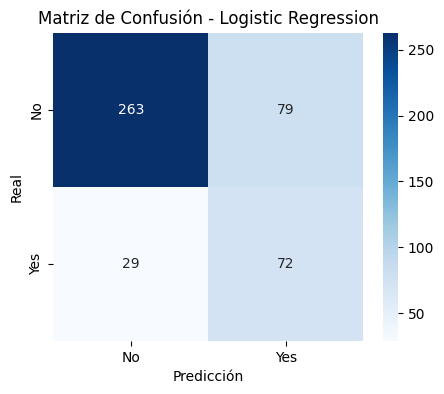

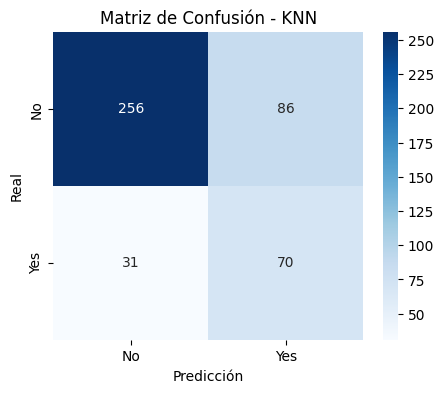

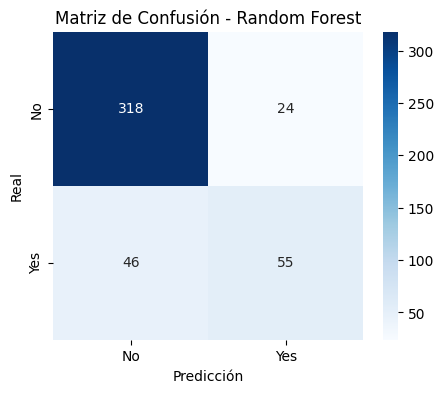

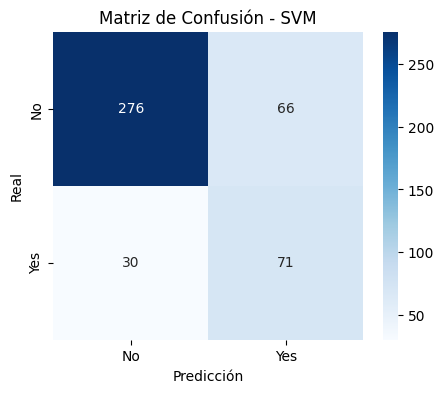

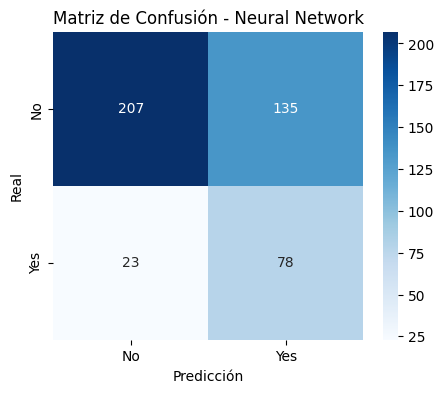

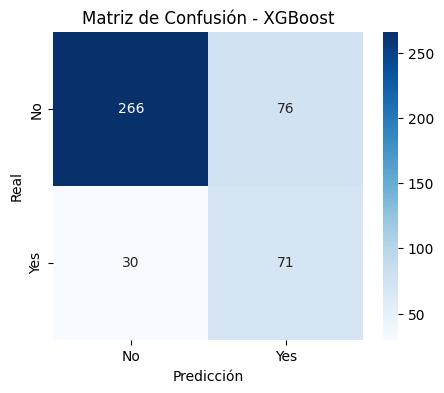

In [37]:
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

# Visualizar para los mejores modelos
for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test
    y_pred = best_model.predict(X_test_final)
    plot_confusion_matrix(model_name, y_test, y_pred)

### Distribución de Probabilidades Predichas vs. Valores Reales

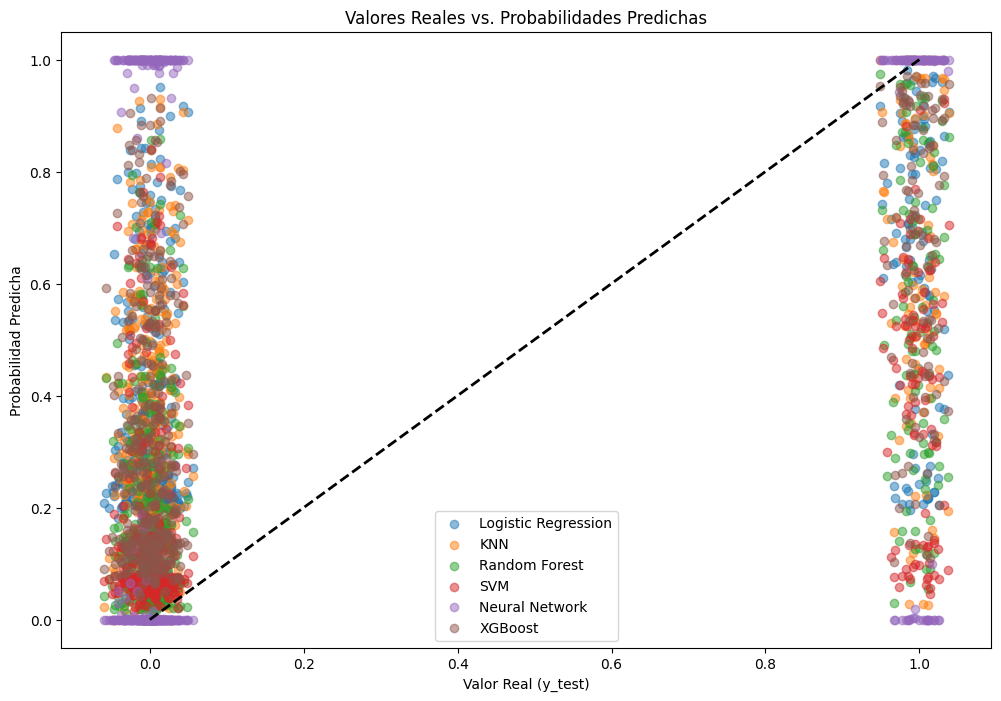

In [38]:
plt.figure(figsize=(12, 8))

jitter = np.random.normal(0, 0.02, size=len(y_test))  # Ruido leve en X para mejor visualización

for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    if hasattr(best_model, "predict_proba"):  # Si el modelo tiene predict_proba
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilidad de la clase positiva
    else:
        y_pred_proba = best_model.predict(X_test_final)  # Predicción directa

    # Agregar dispersión de puntos
    plt.scatter(y_test + jitter, y_pred_proba, alpha=0.5, label=model_name)

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('Valor Real (y_test)')
plt.ylabel('Probabilidad Predicha')
plt.title('Valores Reales vs. Probabilidades Predichas')
plt.legend()
plt.show()

### Curva ROC

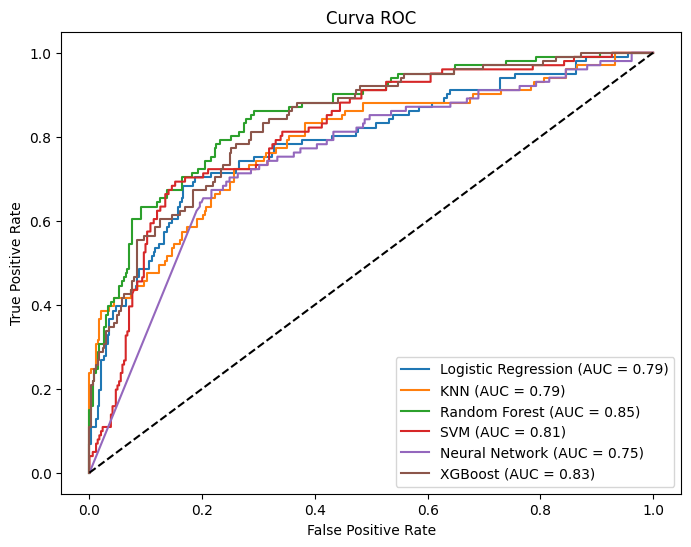

In [39]:
plt.figure(figsize=(8, 6))

for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    if hasattr(best_model, "predict_proba"):  # Verificar si tiene predict_proba
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    else:
        continue  # Si el modelo no tiene predict_proba, lo ignoramos

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Considerar un threshold (umbral) en el modelo Random Forest
Por defecto, los modelos de clasificación usan un umbral de 0.5 para decidir entre clases, pero ajustar este threshold puede mejorar el balance entre Precision y Recall, especialmente en datos desbalanceados.

En lugar de simplemente guardar `RandomForestClassifier.pkl` con el threshold por defecto, podemos:

1. Evaluar el impacto de diferentes umbrales en Precision-Recall y ROC Curve.

2. Seleccionar el threshold óptimo según la métrica más relevante (F1 Score, Recall, etc.).

3. Modificar el modelo para usar este threshold en la predicción final antes de su guardado.

### Visualizar cómo varían las métricas según el threshold 

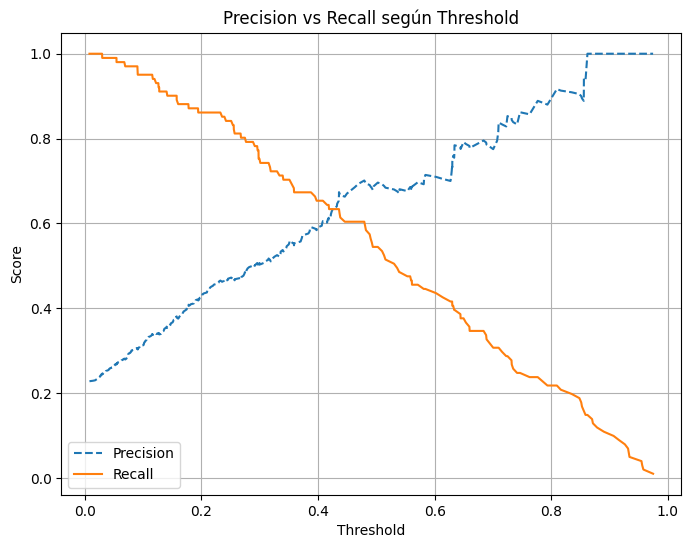

In [40]:
# Obtener probabilidades del mejor modelo (Random Forest)
y_proba = best_models['Random Forest'].predict_proba(X_test)[:, 1]

# Calcular Precision-Recall para diferentes thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Graficar Precision-Recall según threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall según Threshold")
plt.legend()
plt.grid()
plt.show()

El gráfico muestra cómo varían **Precision** y **Recall** según el umbral de clasificación.

A medida que el `threshold' aumenta, la **Precision** sube porque el modelo hace predicciones más conservadoras (menos falsos positivos).

Sin embargo, el **Recall** baja, lo que significa que detectamos menos casos positivos reales.

El punto óptimo es donde **Precision** y **Recall** tienen un buen balance. Generalmente se elige el threshold que maximiza el F1 Score, ya que este es el mejor compromiso entre ambas métricas.

### Optimal `Threshold`

In [41]:
# Calcular F1 Score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[f1_scores.argmax()]  # Umbral con mayor F1 Score

print(f"Optimal Threshold basado en F1 Score: {optimal_threshold:.2f}")

Optimal Threshold basado en F1 Score: 0.44


## Guardar modelo aplicando `ThresholdThreshol`

In [42]:
# Guardamos el modelo junto con el threshold óptimo
joblib.dump((best_models['Random Forest'], optimal_threshold), '../models/classification/RandomForestClassifier.pkl')

['../models/classification/RandomForestClassifier.pkl']